In [1]:
# Import pandas for data manipulation
import pandas as pd
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import seaborn for enhanced plotting
import seaborn as sns
# Import Prophet for time series forecasting
from prophet import Prophet
# Import numpy for numerical operations
import numpy as np

Summary

This analysis focuses on exploring incomming 911 calls with the aim of leveraging the Prophet model for future forecasting. The objective is to gain insights into the patterns and trends of emergency calls and use this information to predict call volumes.

The data is collcted from kaggle: https://www.kaggle.com/datasets/mchirico/montcoalert and made avalible by the user Mike Chirico. The data is of high quality and completeness, yet the accessibility of the data source is not working due to a non-functional link. Consequently, verifying the reliability of the data becomes challenging, as there is no means to validate its accuracy and integrity.



In [2]:
# Load dataset from CSV file
df = pd.read_csv('/content/911.csv')

In [3]:
# Display dataframe structure and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


In [5]:
df.head(5)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [6]:
# Drop unnecessary columns from the dataframe
df.drop(columns=['lat', 'lng'], inplace=True)

In [7]:
df.describe()

,zip,e
count,583323.000000,663522.0
mean,19236.055791,1.0
std,298.222637,0.0
min,1104.000000,1.0
25%,19038.000000,1.0
50%,19401.000000,1.0
75%,19446.000000,1.0
max,77316.000000,1.0


In [8]:
df.isna().sum()
min_date = df['timeStamp'].min()
max_date = df['timeStamp'].max()

print("Minimum Date in Dataset:", min_date)
print("Maximum Date in Dataset:", max_date)



Minimum Date in Dataset: 2015-12-10 14:39:21
Maximum Date in Dataset: 2020-07-29 15:54:08


In [9]:
df.isnull().sum()

,0
desc,0
zip,80199
title,0
timeStamp,0
twp,293
addr,0
e,0


In [10]:
min_date = df['timeStamp'].min()
max_date = df['timeStamp'].max()

print("Minimum Date in Dataset:", min_date)
print("Maximum Date in Dataset:", max_date)


Minimum Date in Dataset: 2015-12-10 14:39:21
Maximum Date in Dataset: 2020-07-29 15:54:08


Create timeseries features from 'timeStamp' column

In [11]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df['datetime'] = df['timeStamp'].dt.floor('h')
df['year'] = df['timeStamp'].dt.year
df['month'] = df['timeStamp'].dt.month
df['day'] = df['timeStamp'].dt.day
df['hour'] = df['timeStamp'].dt.hour
df['day_of_week'] = df['timeStamp'].dt.dayofweek
df['date'] = df['timeStamp'].dt.date
df['month_of_year'] = df['timeStamp'].dt.to_period('M').astype(str)
df['day_of_year'] = df['timeStamp'].dt.year.astype(str) + '_' + df['timeStamp'].dt.dayofyear.astype(str)

Define a function to map months to seasons

In [12]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# Create a new column 'season' based on 'timeStamp'
df['season'] = df['timeStamp'].dt.month.apply(get_season)# Filter out dates between '2016-01-01' and '2019-12-31'
filtered_df = df[(df['timeStamp'] >= '2016-01-01') & (df['timeStamp'] <= '2019-12-31')]

In [13]:
# Filter out dates between '2016-01-01' and '2019-12-31'
filtered_df = df[(df['timeStamp'] >= '2016-01-01') & (df['timeStamp'] <= '2019-12-31')]

Exploratory Data Analysis  

/tmp/ipython-input-1445692444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['category'] = filtered_df['title'].str.split().str[0].str.rstrip(':')


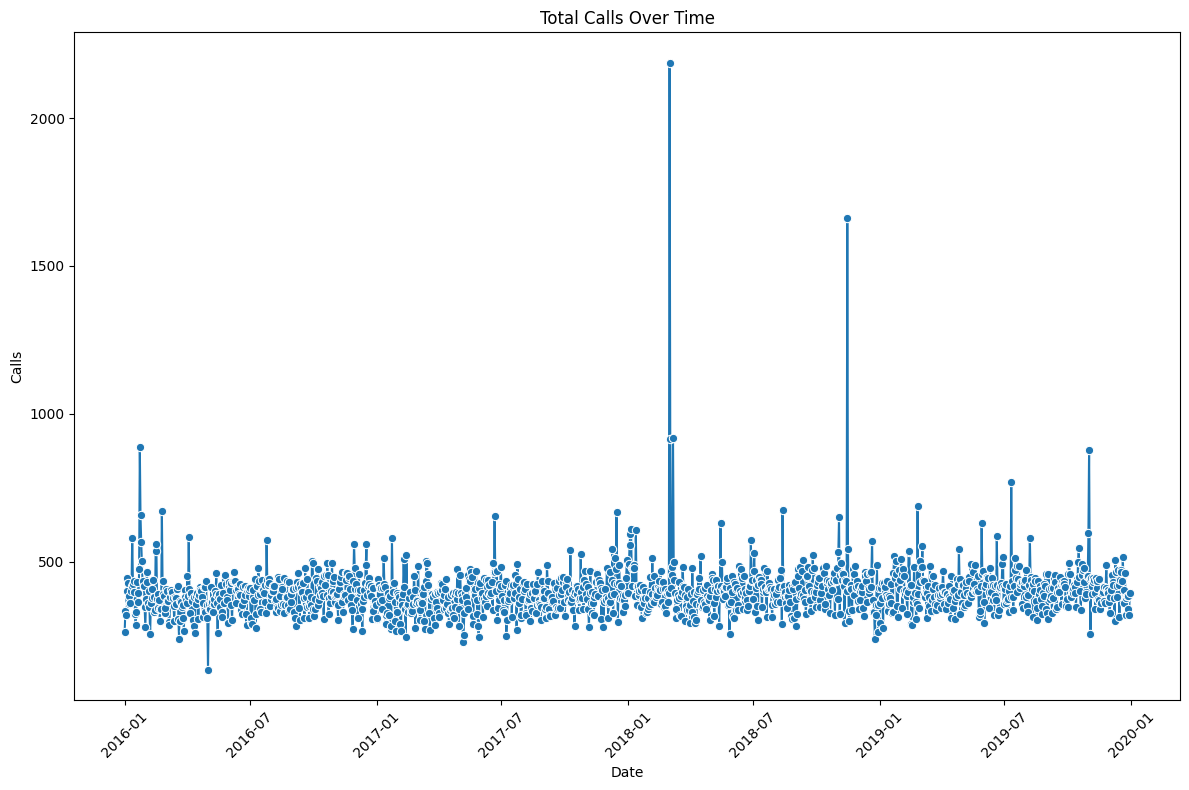

In [14]:
# Create a category column
filtered_df['category'] = filtered_df['title'].str.split().str[0].str.rstrip(':')

# Group the DataFrame by 'date' and 'category', and calculate the sum of 'e' for each group
category_e_sums = filtered_df.groupby(['date', 'category'])['e'].sum().reset_index()

# Sum the 'e' values across categories for each date
total_e_by_date = category_e_sums.groupby('date')['e'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size
# Plot the forecast results
sns.lineplot(data=total_e_by_date, x='date', y='e', marker='o')
plt.title('Total Calls Over Time')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

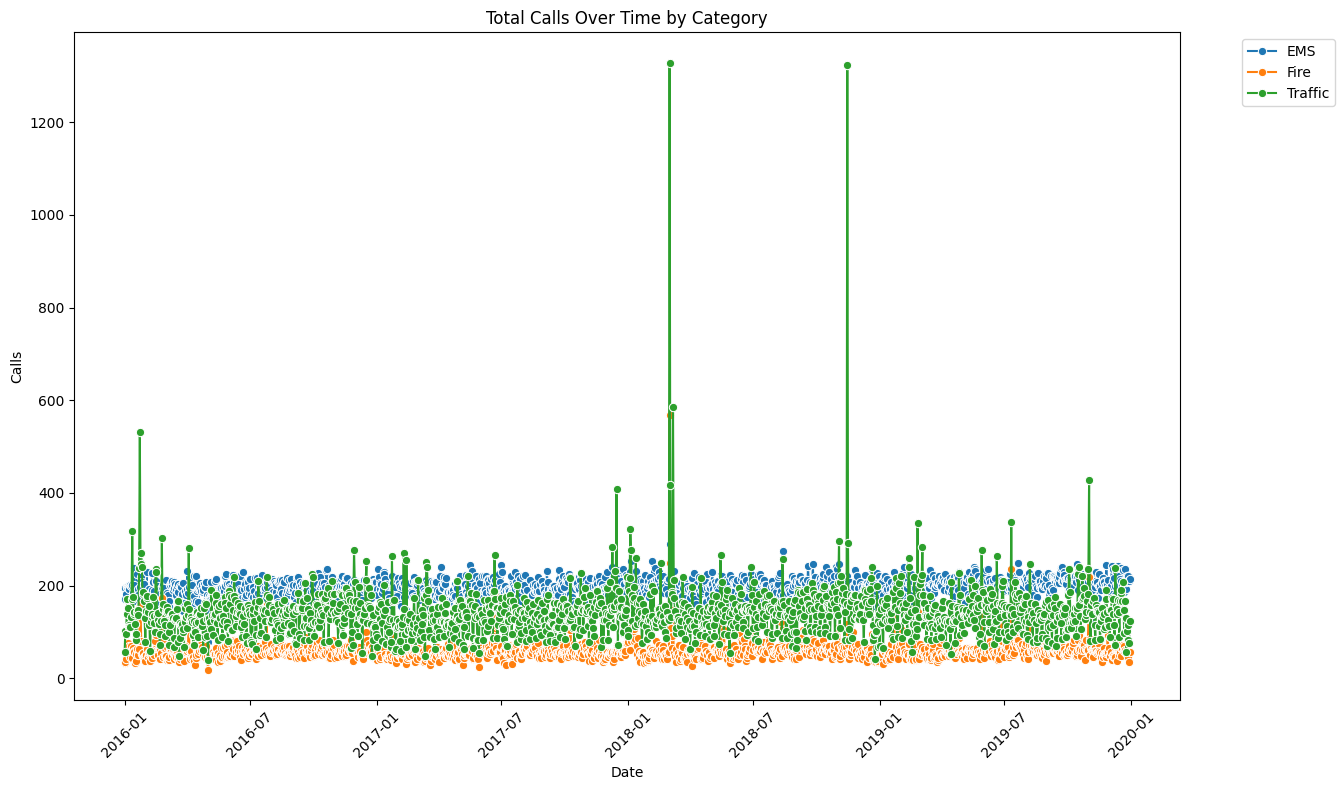

In [15]:
# Group the DataFrame by 'date' and 'category', and calculate the sum of 'e' for each group
category_e_sums = filtered_df.groupby(['date', 'category'])['e'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size
# Plot the forecast results
sns.lineplot(data=category_e_sums, x='date', y='e', hue='category', marker='o')
plt.title('Total Calls Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.xticks(rotation=45)

plt.tight_layout()
# Plot the forecast results
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

It would be beneficial to provide further clarification on the extreme values.

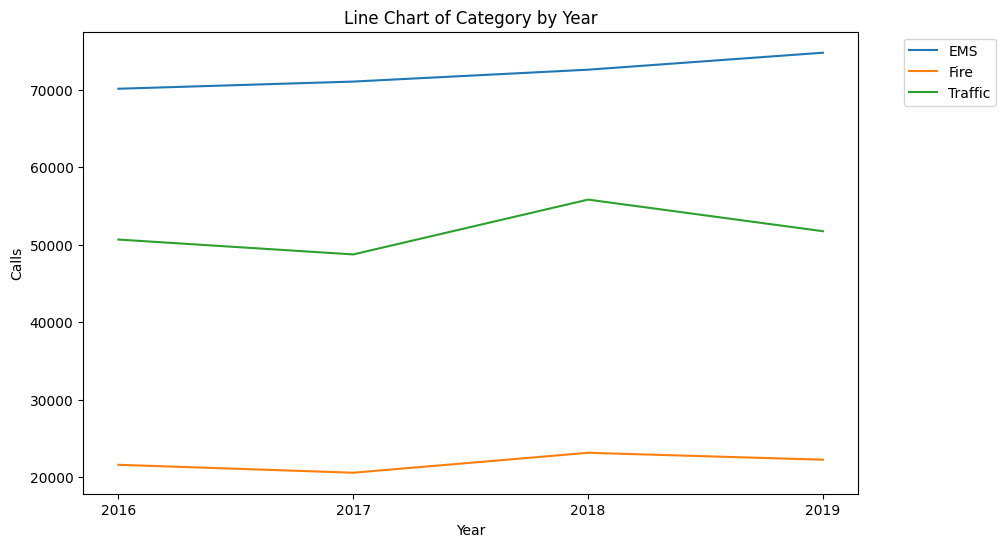

In [16]:
# Group the filtered DataFrame by 'year' and 'category' and count the occurrences
category_by_year = filtered_df.groupby(['year', 'category']).size().unstack()

# Plot the forecast results
# Create a line plot
# Plot the forecast results
category_by_year.plot(kind='line', figsize=(10, 6))
plt.title('Line Chart of Category by Year')
plt.xlabel('Year')
plt.ylabel('Calls')
plt.xticks(range(int(category_by_year.index.min()), int(category_by_year.index.max()) + 1), rotation=0)

plt.legend(title='Category')
# Plot the forecast results
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

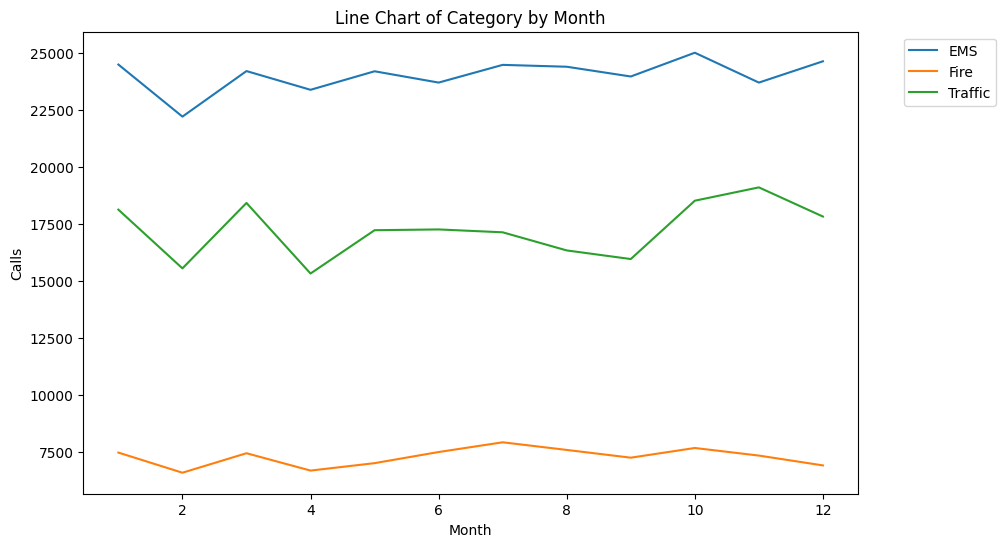

In [17]:
# Group the filtered DataFrame by 'month' and 'category' and count the occurrences
category_by_month = filtered_df.groupby(['month', 'category']).size().unstack()

# Plot the forecast results
# Create a line plot
# Plot the forecast results
category_by_month.plot(kind='line', figsize=(10, 6))
plt.title('Line Chart of Category by Month')
plt.xlabel('Month')
plt.ylabel('Calls')
plt.xticks(rotation=0)

plt.legend(title='Category')
# Plot the forecast results
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.show()

/tmp/ipython-input-4224461944.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=monthly_sum_df, x='month', y='e', palette='Blues')


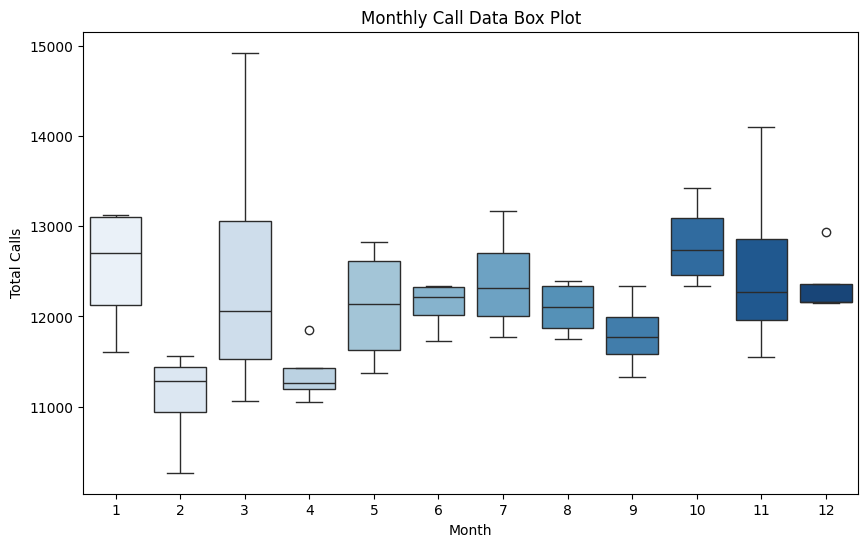

In [18]:
# Plot the forecast results
# Create box plot
monthly_sum_df = filtered_df.groupby(['month_of_year', 'month', 'season'])['e'].sum().reset_index()

# Plot the forecast results
# Plotting the box plot
plt.figure(figsize=(10, 6))
# Plot the forecast results
sns.boxplot(data=monthly_sum_df, x='month', y='e', palette='Blues')
plt.title('Monthly Call Data Box Plot')
plt.xlabel('Month')
plt.ylabel('Total Calls')
plt.show()

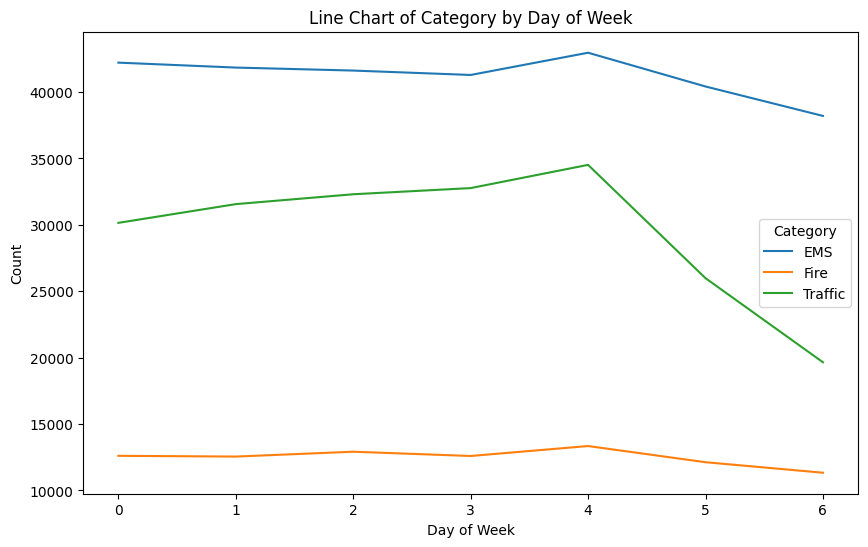

In [19]:
# Group the filtered DataFrame by 'day_of_week' and 'category' and count the occurrences
category_by_dayofweek = filtered_df.groupby(['day_of_week', 'category']).size().unstack()

# Plot the forecast results
# Create a line plot
# Plot the forecast results
category_by_dayofweek.plot(kind='line', figsize=(10, 6))

# Add labels and title
plt.title('Line Chart of Category by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot the forecast results
# Show the plot
plt.legend(title='Category')
plt.show()

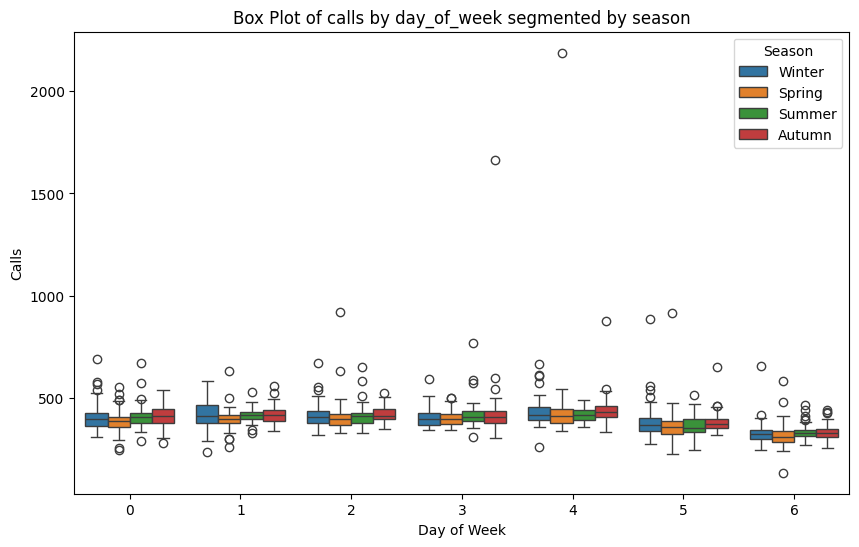

In [20]:
day_of_week_sum_df = filtered_df.groupby(['day_of_week', 'day', 'month', 'season'])['e'].sum().reset_index()

# Plot the forecast results
# Create a box plot segmented by seasons
# Plot the forecast results
# Create the box plot
plt.figure(figsize=(10, 6))
# Plot the forecast results
sns.boxplot(x='day_of_week', y='e', hue='season', data=day_of_week_sum_df)
plt.title('Box Plot of calls by day_of_week segmented by season')
plt.xlabel('Day of Week')
plt.ylabel('Calls')
plt.legend(title='Season')
plt.show()


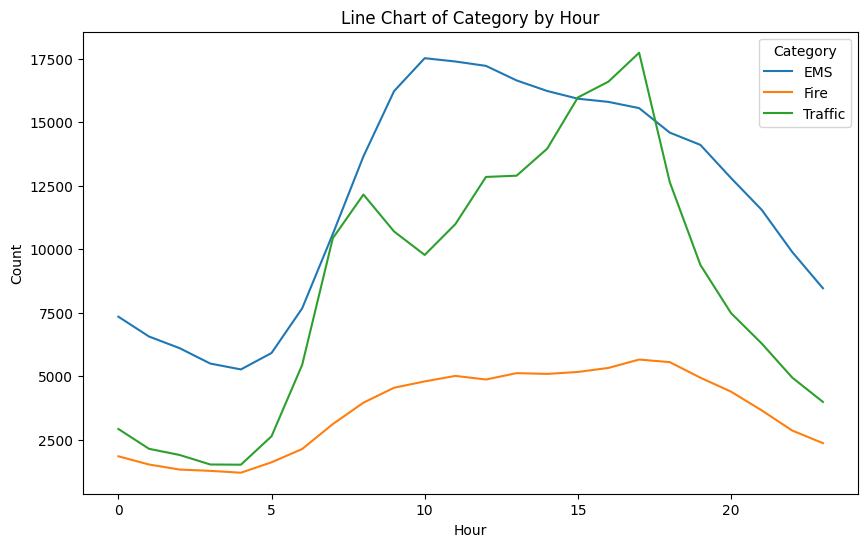

In [21]:
# Group the filtered DataFrame by 'hour' and 'category' and count the occurrences
category_by_hour = filtered_df.groupby(['hour', 'category']).size().unstack()

# Plot the forecast results
# Create a line plot
# Plot the forecast results
category_by_hour.plot(kind='line', figsize=(10, 6))

# Add labels and title
plt.title('Line Chart of Category by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot the forecast results
# Show the plot
plt.legend(title='Category')
plt.show()

/tmp/ipython-input-2872296741.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=hourly_sum_df, x='hour', y='e', palette='tab20_r')


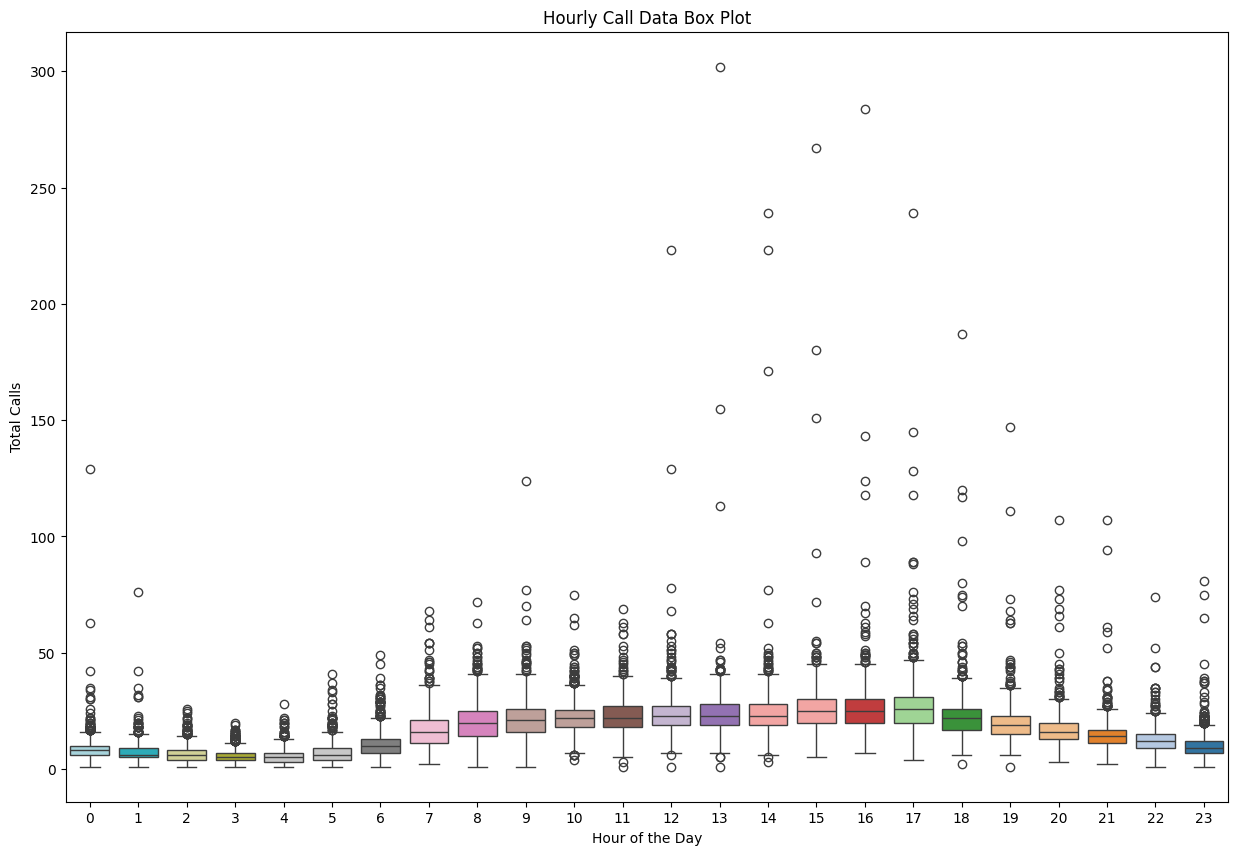

In [22]:
hourly_sum_df = filtered_df.groupby(['day_of_year', 'hour', 'day', 'month', ])['e'].sum().reset_index()

# Plot the forecast results
# Plotting the box plot
plt.figure(figsize=(15, 10))
# Plot the forecast results
sns.boxplot(data=hourly_sum_df, x='hour', y='e', palette='tab20_r')
plt.title('Hourly Call Data Box Plot')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Calls')
plt.show()


Forecasting

In [23]:
# Grouping data by datetime and summing 'e'
df_new = filtered_df.groupby(['datetime'])['e'].sum().reset_index()

# Renaming columns for Prophet
df_new = pd.DataFrame({'ds': df_new['datetime'], 'y': df_new['e']})

Creating holiday features

In [24]:
pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.1 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732000 sha256=41dbb9b3498e13e498dc1ad0ac836e6fa6b5485aa39fb2d422b91961831d60f5
  Stored in directory: /root/.cache/pip/wheels/8f/bd/f9/5c4c39b529e0322b08979e1c465e203218bc2cca75d20f7df5
Successfully built pymeeus


In [25]:
from workalendar.usa import UnitedStates

# Initialize the UnitedStates calendar
cal = UnitedStates()

# Define the range of years for which you want to generate holidays
start_year = 2016
end_year = 2019

# Generate the list of holidays for each year
holiday_list = []
for year in range(start_year, end_year + 1):
    # Get the list of holidays for the current year
    holidays = cal.holidays(year)
    for date, name in holidays:
        holiday_list.append([date, name])

In [26]:
# Create a DataFrame from the list of holidays
holiday_df = pd.DataFrame(holiday_list, columns=['ds', 'holiday'])

# Convert 'ds' column to datetime
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [27]:
# Initialize Prophet model with custom holidays
# Initialize the Prophet model
prophet_model = Prophet(holidays=holiday_df)

# Add built-in holidays if needed
prophet_model.add_country_holidays(country_name='US')  # Add US holidays

# Fit the model
# Fit the Prophet model to the data
prophet_model.fit(df_new)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprc0h3zjd/ea8c_135.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprc0h3zjd/zo1l78km.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78582', 'data', 'file=/tmp/tmprc0h3zjd/ea8c_135.json', 'init=/tmp/tmprc0h3zjd/zo1l78km.json', 'output', 'file=/tmp/tmprc0h3zjd/prophet_modelq9fdfgij/prophet_model-20250807023240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Train/test data

In [33]:
# Splitting the data into training and testing sets
train_size = int(len(df_new) * 0.7)  # 70% training, 30% testing
train_df = df_new[:train_size]
test_df = df_new[train_size:]

# Make future predictions with the model
# Making predictions on the testing data
# Make future predictions with the model
forecast = prophet_model.predict(test_df)

# Make future predictions with the model
# Extracting actual and predicted values
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

# Display predictions including confidence intervals
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
10487,2019-12-30 19:00:00,20.722055,11.368924,29.810250
10488,2019-12-30 20:00:00,17.649245,7.912769,27.496562
10489,2019-12-30 21:00:00,14.790965,5.781529,24.421334
10490,2019-12-30 22:00:00,12.463573,2.437934,22.187068
10491,2019-12-30 23:00:00,10.714004,0.798871,20.190463


Error metrics

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
# Calculating evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Printing the evaluation metrics
print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("R-squared (R2): ", r2)
print("Mean Absolute Percentage Error (MAPE): ", mape)



Mean Absolute Error (MAE):  4.742843708704754
Mean Squared Error (MSE):  63.928052127469144
Root Mean Squared Error (RMSE):  7.995501993462896
R-squared (R2):  0.47638844788377843
Mean Absolute Percentage Error (MAPE):  41.13506417980941


Plotting predicted vs original vlaues

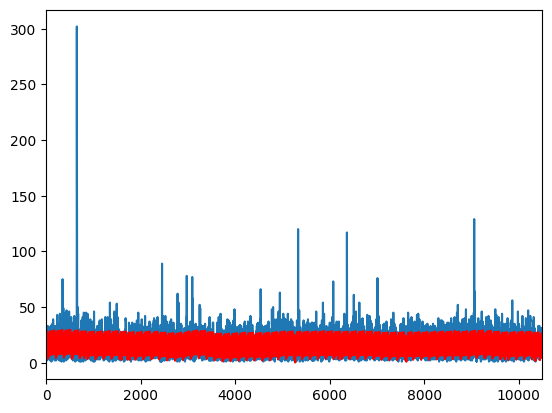

In [30]:
# Make future predictions with the model
# Plotting original vs predicted values
# Plot the forecast results
plt.plot(y_true, label='Original')
# Initialize the Prophet model
plt.plot(y_pred, color='red', label='FBProphet')

# Set the data range on the x-axis
start_date_index = 0  # Assuming the start index corresponds to the start date of your data
end_date_index = start_date_index + len(y_true)  # Assuming the end index corresponds to the end date of your data
plt.xlim(start_date_index, end_date_index)

plt.show()

Zooming in on one year of data

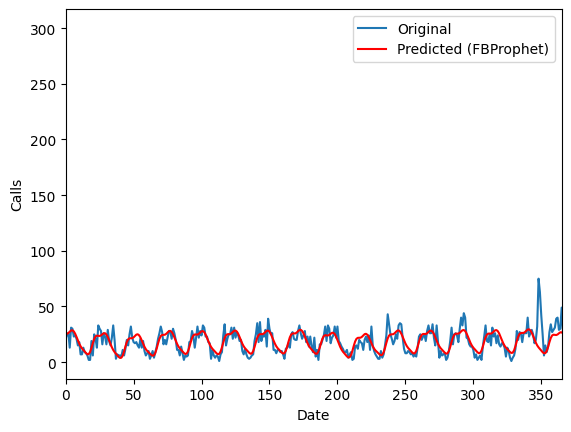

In [31]:
# Find the indices corresponding to the date range
start_date = '2016-01-01'
end_date = '2016-12-31'


date_index = pd.date_range(start=start_date, end=end_date)
start_date_index = np.where(date_index == pd.to_datetime(start_date))[0][0]
end_date_index = np.where(date_index == pd.to_datetime(end_date))[0][0]

# Make future predictions with the model
# Plotting original vs predicted values
# Plot the forecast results
plt.plot(y_true, label='Original')
# Initialize the Prophet model
plt.plot(y_pred, color='red', label='Predicted (FBProphet)')

# Set the x-axis limits to the specified date range
plt.xlim(start_date_index, end_date_index)

# Add labels to the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Calls')

# Add legend
plt.legend()

plt.show()


Predict future outcomes

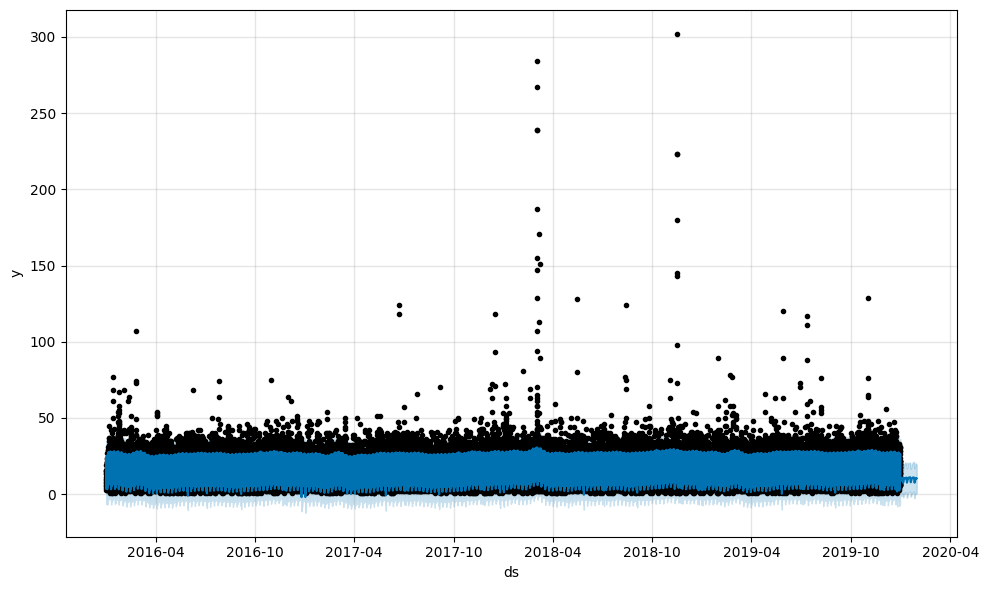

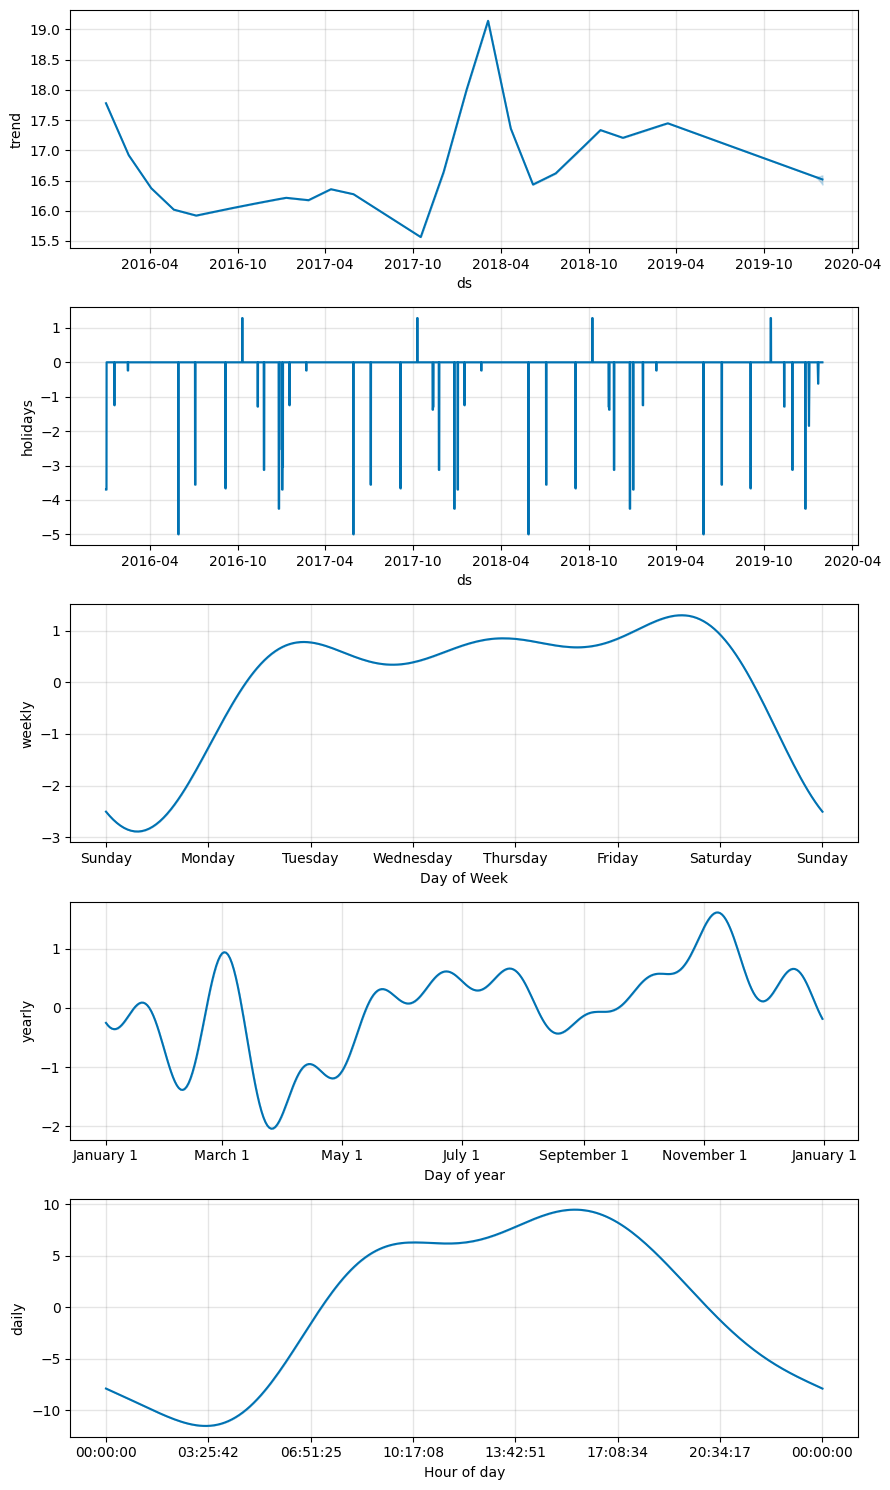

In [32]:
# Generating future dates for forecasting
future_df = prophet_model.make_future_dataframe(periods=30, freq='D')

# Forecasting for future dates
# Make future predictions with the model
forecast_df = prophet_model.predict(future_df)

# Plot forecast components (trend, yearly, etc.)
# Plotting forecast and components
# Plot the forecast results
fig1 = prophet_model.plot(forecast_df)
# Plot the forecast results
fig2 = prophet_model.plot_components(forecast_df)
plt.show()

In [44]:
# Convert to datetime and extract date only
df['ds'] = pd.to_datetime(df['ds']).dt.date

# Group by date and count calls
df_daily = df.groupby('ds').size().reset_index(name='y')

# Convert 'ds' back to datetime format (Prophet needs this)
df_daily['ds'] = pd.to_datetime(df_daily['ds'])

from prophet import Prophet

model = Prophet()
model.fit(df_daily)

# Make future predictions
future = model.make_future_dataframe(periods=30)  # 30 days ahead
forecast = model.predict(future)

# Merge actuals into forecast
df_forecast_merged = pd.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    df_daily,
    on='ds',
    how='left'
)

# Drop rows without actual values
df_forecast_merged = df_forecast_merged.dropna(subset=['y'])

# Round and format
df_forecast_merged['yhat'] = df_forecast_merged['yhat'].round().astype(int)
df_forecast_merged['y'] = df_forecast_merged['y'].astype(int)
df_forecast_merged['CI (95%)'] = df_forecast_merged.apply(
    lambda row: f"{int(row['yhat_lower'])} – {int(row['yhat_upper'])}", axis=1
)

# Preview table
result_table = df_forecast_merged[['ds', 'y', 'yhat', 'CI (95%)']].head(5)
result_table.columns = ['Date', 'Actual Calls', 'Predicted (yhat)', '95% CI (lower - upper)']

from tabulate import tabulate
print(tabulate(result_table, headers='keys', tablefmt='github'))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprc0h3zjd/jtp_mqlg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprc0h3zjd/zt1nq0jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61845', 'data', 'file=/tmp/tmprc0h3zjd/jtp_mqlg.json', 'init=/tmp/tmprc0h3zjd/zt1nq0jv.json', 'output', 'file=/tmp/tmprc0h3zjd/prophet_modelnvn73f11/prophet_model-20250807035945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


|    | Date                |   Actual Calls |   Predicted (yhat) | 95% CI (lower - upper)   |
|----|---------------------|----------------|--------------------|--------------------------|
|  0 | 2015-12-10 00:00:00 |            114 |                412 | 316 – 514                |
|  1 | 2015-12-11 00:00:00 |            391 |                430 | 325 – 528                |
|  2 | 2015-12-12 00:00:00 |            402 |                375 | 272 – 482                |
|  3 | 2015-12-13 00:00:00 |            316 |                331 | 224 – 443                |
|  4 | 2015-12-14 00:00:00 |            444 |                405 | 294 – 505                |
